In [1]:
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from collections import Counter

import pandas as pd
import numpy as np

In [2]:
#settings
EPOCHS = 30
BATCH_SIZE = 256
CLASS_WEIGHT=[1, 1, 1]
HIDDEN_DIM=64
#
MAX_LEN = 400

# Data Upload

In [4]:
df = pd.read_csv('HateSpeechTurkish.csv', encoding="utf-8-sig")

In [5]:
#df = df.head(1000)

In [6]:
history = {'loss': [], 'f1': [], 'val_loss': [], 'val_f1': []}

In [7]:
main_result = {'model_name': [],
               'Accuracy': [], 'Precision': [], 'Recall': [] , 'F1': [],
               'Train_Time': [] , 'Infer_Time': []}

In [8]:
if df.isnull().values.any():
    print(df.isnull().sum())
    df.dropna(inplace=True)

row_id                      0
tweet                       0
etiket                     55
corrected_tweet             0
correct_normalize_tweet     0
dtype: int64


In [9]:
print("After drop null value:")
print(df.isnull().sum())

After drop null value:
row_id                     0
tweet                      0
etiket                     0
corrected_tweet            0
correct_normalize_tweet    0
dtype: int64


In [10]:
df['etiket'].value_counts()

etiket
hiçbiri      7667
nefret       2336
saldırgan     166
Name: count, dtype: int64

In [11]:
print("Original data class distribution:", Counter(df['etiket']))

Original data class distribution: Counter({'hiçbiri': 7667, 'nefret': 2336, 'saldırgan': 166})


In [12]:
label_mapping={
 'nefret':     0,
 'saldırgan':  1,
 'hiçbiri':    2,
}

In [13]:
y = df['etiket'].map(label_mapping)

In [14]:
x = df['correct_normalize_tweet']

# FT-TRW2V(FineTune turkish Word2Vec)

In [16]:
from gensim.models import KeyedVectors

path = "embedding/trmodel_finetune.kv"  # değiştir!
w2v_model = KeyedVectors.load_word2vec_format(path, binary=True)
emb_dim = w2v_model.vector_size

In [17]:
print(emb_dim)

400


# NLP

In [19]:
special_tokens = ["<pad>", "<sos>", "<eos>", "<unk>"]
PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, UNK_TOKEN = special_tokens
PAD_IDX, SOS_IDX, EOS_IDX, UNK_IDX = 0, 1, 2, 3

In [20]:
tokenized_sentences = [sentence.split() for sentence in x]
all_tokens = [token for sent in tokenized_sentences for token in sent]
vocab = special_tokens + sorted(set(all_tokens))
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}


In [21]:
import numpy as np
import torch

embedding_matrix = np.zeros((len(word2idx), emb_dim))
for word, idx in word2idx.items():
    if word in w2v_model:
        embedding_matrix[idx] = w2v_model[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(emb_dim,))
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

In [22]:
def encode_sentence(sentence, word2idx, max_len):
    tokens = sentence.split()
    indices = [word2idx.get(w, UNK_IDX) for w in tokens]
    indices = [SOS_IDX] + indices + [EOS_IDX]
    if len(indices) < max_len:
        indices += [PAD_IDX] * (max_len - len(indices))
    else:
        indices = indices[:max_len]
    return indices


encoded_data = [encode_sentence(sent, word2idx, MAX_LEN) for sent in x]


X = encoded_data

# Test train split

In [24]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

# Her sınıf için hedef: 2300 örnek
sampling_strategy = {
    0: 2300,  #  nefret
    1: 2300,  #  salfırgan
    2: 2300   # hiçbiri 
}

# SMOTE yalnızca sınıf 2'ye uygulanıyor
pipeline = Pipeline([
    ("smote", SMOTE(sampling_strategy={1: 2300}, random_state=42)),
    ("undersample", RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42))
])

# Uygula
X, y = pipeline.fit_resample(X, y)

# Kontrol
print("Yeni sınıf dağılımı:", Counter(y))

C:\Users\ilker\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\ilker\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Yeni sınıf dağılımı: Counter({0: 2300, 1: 2300, 2: 2300})


C:\Users\ilker\anaconda3\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
C:\Users\ilker\anaconda3\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [25]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=42)
print("x_train",len(X_train))
print("x_test",len(X_test))
print("y_train",len(y_train))
print("y_test",len(y_test))
print("Number of unique classes in y_test:",len(set(y_test)))

x_train 6210
x_test 690
y_train 6210
y_test 690
Number of unique classes in y_test: 3


In [26]:
src_tensor = torch.tensor(X_train, dtype=torch.long)
trg_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long)
src_tensor_test = torch.tensor(X_test, dtype=torch.long)
trg_tensor_test = torch.tensor(y_test.to_numpy(), dtype=torch.long)

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
sample = torch.tensor(X_test[10:11], dtype=torch.long).to(device)  # Sample for inferece time test

cuda


In [28]:
import torch
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(src_tensor, trg_tensor)
val_dataset = TensorDataset(src_tensor_test, trg_tensor_test)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# AdditiveAttention + FT-W2V

In [30]:
model_name='bahdanau_FT-W2V'

In [31]:
attention= 'additive'

In [32]:
OUTPUT_DIM =len(set(y))

In [33]:
from train.trainSeq2Seq import train_seq2seq_model

model, history, train_time = train_seq2seq_model(
    attention_module=attention,
    embedding_matrix=embedding_matrix,
    word2idx=word2idx,
    output_dim=OUTPUT_DIM,
    train_loader=train_loader,
    val_loader=val_loader,
    PAD_IDX=PAD_IDX,
    model_name=model_name,
    embedding_dim=emb_dim,
    hidden_dim=HIDDEN_DIM,
    EPOCHS=EPOCHS,
    CLASS_W=CLASS_WEIGHT,
)

Epoch 01 | Loss: 1.0944, F1: 0.3422 | Val_Loss: 1.0781, Val_F1: 0.2581
Epoch 02 | Loss: 1.0586, F1: 0.4956 | Val_Loss: 1.0373, Val_F1: 0.4623
Epoch 03 | Loss: 1.0006, F1: 0.5254 | Val_Loss: 0.9640, Val_F1: 0.5279
Epoch 04 | Loss: 0.9104, F1: 0.5724 | Val_Loss: 0.8628, Val_F1: 0.5216
Epoch 05 | Loss: 0.8037, F1: 0.5940 | Val_Loss: 0.7606, Val_F1: 0.6148
Epoch 06 | Loss: 0.7156, F1: 0.6288 | Val_Loss: 0.6880, Val_F1: 0.6366
Epoch 07 | Loss: 0.6572, F1: 0.6480 | Val_Loss: 0.6425, Val_F1: 0.6522
Epoch 08 | Loss: 0.6196, F1: 0.6624 | Val_Loss: 0.6235, Val_F1: 0.6466
Epoch 09 | Loss: 0.5985, F1: 0.6832 | Val_Loss: 0.6113, Val_F1: 0.6661
Epoch 10 | Loss: 0.5838, F1: 0.6958 | Val_Loss: 0.6048, Val_F1: 0.6572
Epoch 11 | Loss: 0.5779, F1: 0.6992 | Val_Loss: 0.5995, Val_F1: 0.6720
Epoch 12 | Loss: 0.5721, F1: 0.7201 | Val_Loss: 0.5946, Val_F1: 0.6768
Epoch 13 | Loss: 0.5580, F1: 0.7352 | Val_Loss: 0.5903, Val_F1: 0.6955
Epoch 14 | Loss: 0.5446, F1: 0.7450 | Val_Loss: 0.5866, Val_F1: 0.6993
Epoch 

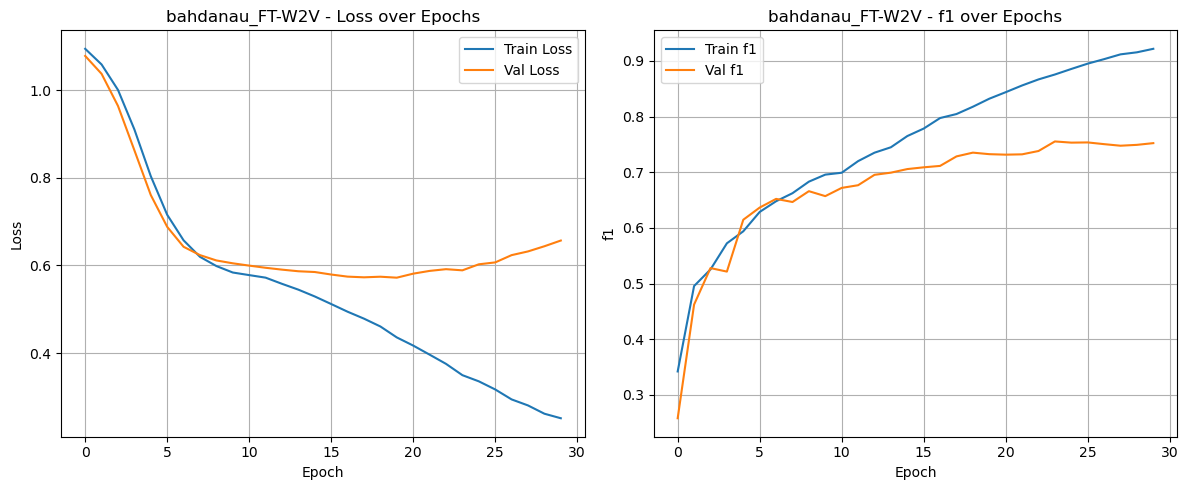

📈 Training history saved to: plots/saved/bahdanau_FT-W2V_plot.png


In [34]:
from plots.loss_val_plot import plot_training_history

plot_training_history(history, model_name=model_name)


🔍 Test Metrikleri - bahdanau_FT-W2V
Accuracy  : 0.7449
Precision : 0.7575
Recall    : 0.7494
F1 Score  : 0.7524


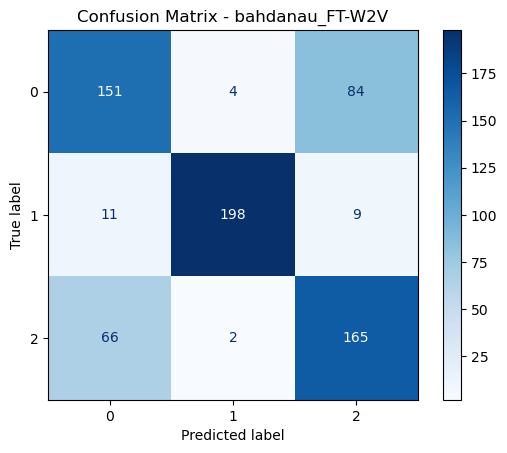

📌 Confusion matrix saved to: plots/saved/bahdanau_FT-W2V_csmtx.png


In [35]:
from plots.eval_plot_conf_mtx import evaluate_and_plot_confusion_matrix

metrics = evaluate_and_plot_confusion_matrix(
    model=model,
    src_tensor=src_tensor_test,
    trg_tensor=trg_tensor_test,
    device=device,
    model_name=model_name
)

In [36]:
def test_inference(model,sample):
    start_infer = time.time()
    
    with torch.no_grad():
        output = model(sample)
        pred = output.argmax(dim=1).item()
        
    end_infer = time.time()
    
    infer_time = (end_infer - start_infer )* 1000
    
    print(f"\n🧠 Prediction for sample #10: Class {pred}")
    print(f"⚡ Inference Time for one sample : {infer_time:.2f} ms")
    return infer_time

In [37]:
infer_time = test_inference(model,sample)


🧠 Prediction for sample #10: Class 1
⚡ Inference Time for one sample : 2.72 ms


In [38]:
[main_result[k].append(v) for k, v in zip(['model_name',
                                           'Accuracy', 'Precision', 'Recall','F1',
                                           'Train_Time','Infer_Time'], [model_name,
                                                                       metrics['accuracy'], metrics['precision'], metrics['recall'],metrics['f1'],
                                                                      train_time, infer_time])]


[None, None, None, None, None, None, None]

In [39]:
main_result

{'model_name': ['bahdanau_FT-W2V'],
 'Accuracy': [0.744927536231884],
 'Precision': [0.7574679402564778],
 'Recall': [0.7494035167838765],
 'F1': [0.7523891091502352],
 'Train_Time': [38990.96417427063],
 'Infer_Time': [2.719402313232422]}

# AdditiveAttention + FreeEmbedding

In [41]:
model_name='bahdanau_FE'

In [42]:
model, history, train_time = train_seq2seq_model(
    attention_module=attention,
    embedding_matrix=None,
    word2idx=word2idx,
    output_dim=OUTPUT_DIM,
    train_loader=train_loader,
    val_loader=val_loader,
    PAD_IDX=PAD_IDX,
    model_name=model_name,
    embedding_dim=emb_dim,
    hidden_dim=HIDDEN_DIM,
    EPOCHS=EPOCHS,
    CLASS_W=CLASS_WEIGHT,
)

Epoch 01 | Loss: 1.1023, F1: 0.3357 | Val_Loss: 1.0944, Val_F1: 0.3615
Epoch 02 | Loss: 1.0965, F1: 0.3365 | Val_Loss: 1.0919, Val_F1: 0.3802
Epoch 03 | Loss: 1.0926, F1: 0.3698 | Val_Loss: 1.0868, Val_F1: 0.3777
Epoch 04 | Loss: 1.0839, F1: 0.4136 | Val_Loss: 1.0815, Val_F1: 0.3937
Epoch 05 | Loss: 1.0739, F1: 0.4319 | Val_Loss: 1.0706, Val_F1: 0.4121
Epoch 06 | Loss: 1.0596, F1: 0.4586 | Val_Loss: 1.0554, Val_F1: 0.4489
Epoch 07 | Loss: 1.0383, F1: 0.4881 | Val_Loss: 1.0356, Val_F1: 0.4869
Epoch 08 | Loss: 1.0102, F1: 0.5147 | Val_Loss: 0.9974, Val_F1: 0.5271
Epoch 09 | Loss: 0.9420, F1: 0.5761 | Val_Loss: 0.9310, Val_F1: 0.5925
Epoch 10 | Loss: 0.8754, F1: 0.6064 | Val_Loss: 0.8581, Val_F1: 0.6166
Epoch 11 | Loss: 0.8225, F1: 0.6263 | Val_Loss: 0.8129, Val_F1: 0.6376
Epoch 12 | Loss: 0.7786, F1: 0.6398 | Val_Loss: 0.8294, Val_F1: 0.6178
Epoch 13 | Loss: 0.7671, F1: 0.6429 | Val_Loss: 0.7879, Val_F1: 0.6351
Epoch 14 | Loss: 0.7159, F1: 0.6656 | Val_Loss: 0.7599, Val_F1: 0.6336
Epoch 

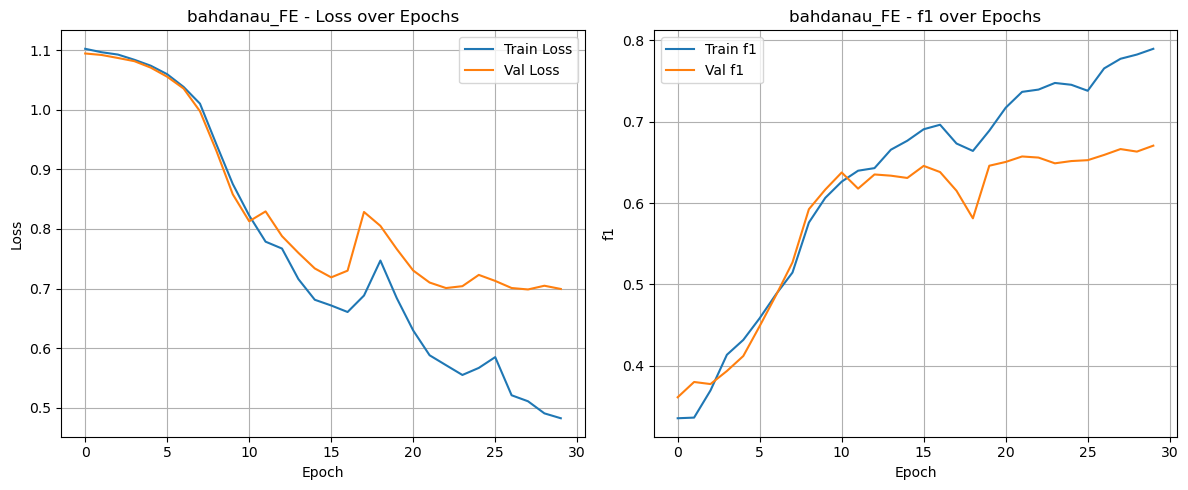

📈 Training history saved to: plots/saved/bahdanau_FE_plot.png


In [43]:
from plots.loss_val_plot import plot_training_history

plot_training_history(history, model_name=model_name)


🔍 Test Metrikleri - bahdanau_FE
Accuracy  : 0.6652
Precision : 0.6712
Recall    : 0.6708
F1 Score  : 0.6705


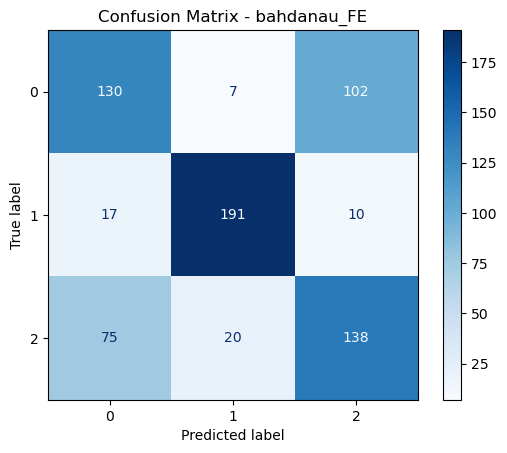

📌 Confusion matrix saved to: plots/saved/bahdanau_FE_csmtx.png


In [44]:
from plots.eval_plot_conf_mtx import evaluate_and_plot_confusion_matrix

metrics = evaluate_and_plot_confusion_matrix(
    model=model,
    src_tensor=src_tensor_test,
    trg_tensor=trg_tensor_test,
    device=device,
    model_name=model_name
)

In [45]:
infer_time = test_inference(model,sample)


🧠 Prediction for sample #10: Class 1
⚡ Inference Time for one sample : 2.05 ms


In [46]:
[main_result[k].append(v) for k, v in zip(['model_name',
                                           'Accuracy', 'Precision', 'Recall','F1',
                                           'Train_Time','Infer_Time'], [model_name,
                                                                       metrics['accuracy'], metrics['precision'], metrics['recall'],metrics['f1'],
                                                                      train_time, infer_time])]


[None, None, None, None, None, None, None]

# DotProduct + FT-W2V

In [48]:
model_name='Luong_FT-W2V'

In [49]:
attention= 'dot'

In [50]:
model, history, train_time = train_seq2seq_model(
    attention_module=attention,
    embedding_matrix=embedding_matrix,
    word2idx=word2idx,
    output_dim=OUTPUT_DIM,
    train_loader=train_loader,
    val_loader=val_loader,
    PAD_IDX=PAD_IDX,
    model_name=model_name,
    embedding_dim=emb_dim,
    hidden_dim=HIDDEN_DIM,
    EPOCHS=EPOCHS,
    CLASS_W=CLASS_WEIGHT,
)

Epoch 01 | Loss: 1.0932, F1: 0.3779 | Val_Loss: 1.0801, Val_F1: 0.4024
Epoch 02 | Loss: 1.0632, F1: 0.5106 | Val_Loss: 1.0379, Val_F1: 0.4545
Epoch 03 | Loss: 1.0045, F1: 0.5250 | Val_Loss: 0.9590, Val_F1: 0.5036
Epoch 04 | Loss: 0.9103, F1: 0.5476 | Val_Loss: 0.8547, Val_F1: 0.5525
Epoch 05 | Loss: 0.8037, F1: 0.5818 | Val_Loss: 0.7612, Val_F1: 0.5906
Epoch 06 | Loss: 0.7246, F1: 0.6096 | Val_Loss: 0.6971, Val_F1: 0.6125
Epoch 07 | Loss: 0.6775, F1: 0.6289 | Val_Loss: 0.6537, Val_F1: 0.6249
Epoch 08 | Loss: 0.6373, F1: 0.6540 | Val_Loss: 0.6289, Val_F1: 0.6395
Epoch 09 | Loss: 0.6173, F1: 0.6670 | Val_Loss: 0.6176, Val_F1: 0.6615
Epoch 10 | Loss: 0.5999, F1: 0.6759 | Val_Loss: 0.6094, Val_F1: 0.6710
Epoch 11 | Loss: 0.5904, F1: 0.6776 | Val_Loss: 0.6063, Val_F1: 0.6443
Epoch 12 | Loss: 0.5809, F1: 0.6871 | Val_Loss: 0.6038, Val_F1: 0.6588
Epoch 13 | Loss: 0.5779, F1: 0.6900 | Val_Loss: 0.6046, Val_F1: 0.6704
Epoch 14 | Loss: 0.5686, F1: 0.7005 | Val_Loss: 0.6037, Val_F1: 0.6663
Epoch 

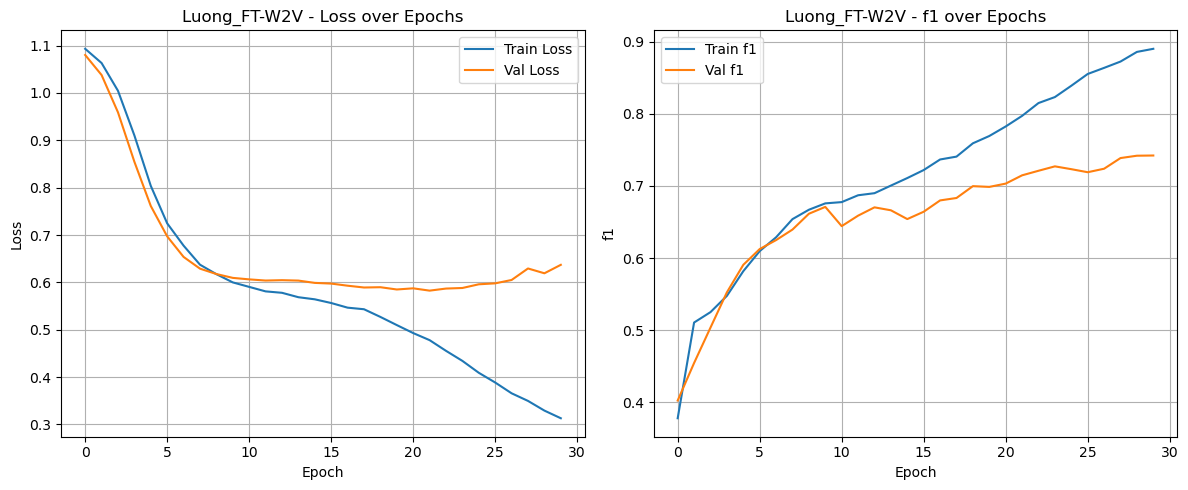

📈 Training history saved to: plots/saved/Luong_FT-W2V_plot.png


In [51]:
from plots.loss_val_plot import plot_training_history

plot_training_history(history, model_name=model_name)


🔍 Test Metrikleri - Luong_FT-W2V
Accuracy  : 0.7362
Precision : 0.7524
Recall    : 0.7399
F1 Score  : 0.7423


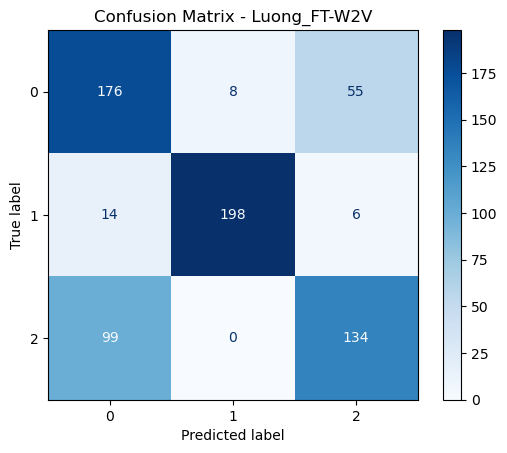

📌 Confusion matrix saved to: plots/saved/Luong_FT-W2V_csmtx.png


In [52]:
from plots.eval_plot_conf_mtx import evaluate_and_plot_confusion_matrix

metrics = evaluate_and_plot_confusion_matrix(
    model=model,
    src_tensor=src_tensor_test,
    trg_tensor=trg_tensor_test,
    device=device,
    model_name=model_name
)

In [53]:
infer_time = test_inference(model,sample)


🧠 Prediction for sample #10: Class 1
⚡ Inference Time for one sample : 1.18 ms


In [54]:
[main_result[k].append(v) for k, v in zip(['model_name',
                                           'Accuracy', 'Precision', 'Recall','F1',
                                           'Train_Time','Infer_Time'], [model_name,
                                                                       metrics['accuracy'], metrics['precision'], metrics['recall'],metrics['f1'],
                                                                      train_time, infer_time])]


[None, None, None, None, None, None, None]

# DotProduct + FE

In [56]:
model_name='Luong_FE'

In [57]:
model, history, train_time = train_seq2seq_model(
    attention_module=attention,
    embedding_matrix=None,
    word2idx=word2idx,
    output_dim=OUTPUT_DIM,
    train_loader=train_loader,
    val_loader=val_loader,
    PAD_IDX=PAD_IDX,
    model_name=model_name,
    embedding_dim=emb_dim,
    hidden_dim=HIDDEN_DIM,
    EPOCHS=EPOCHS,
    CLASS_W=CLASS_WEIGHT,
)

Epoch 01 | Loss: 1.0992, F1: 0.3368 | Val_Loss: 1.0953, Val_F1: 0.3275
Epoch 02 | Loss: 1.0966, F1: 0.3417 | Val_Loss: 1.0939, Val_F1: 0.3545
Epoch 03 | Loss: 1.0915, F1: 0.3865 | Val_Loss: 1.0898, Val_F1: 0.3723
Epoch 04 | Loss: 1.0856, F1: 0.3920 | Val_Loss: 1.0836, Val_F1: 0.4247
Epoch 05 | Loss: 1.0790, F1: 0.4310 | Val_Loss: 1.0768, Val_F1: 0.4330
Epoch 06 | Loss: 1.0685, F1: 0.4414 | Val_Loss: 1.0677, Val_F1: 0.4305
Epoch 07 | Loss: 1.0554, F1: 0.4576 | Val_Loss: 1.0521, Val_F1: 0.4811
Epoch 08 | Loss: 1.0355, F1: 0.5000 | Val_Loss: 1.0340, Val_F1: 0.4953
Epoch 09 | Loss: 1.0098, F1: 0.5312 | Val_Loss: 1.0106, Val_F1: 0.5024
Epoch 10 | Loss: 0.9806, F1: 0.5489 | Val_Loss: 0.9846, Val_F1: 0.5249
Epoch 11 | Loss: 0.9447, F1: 0.5648 | Val_Loss: 0.9579, Val_F1: 0.5289
Epoch 12 | Loss: 0.9066, F1: 0.5900 | Val_Loss: 0.9313, Val_F1: 0.5459
Epoch 13 | Loss: 0.8625, F1: 0.6041 | Val_Loss: 0.9052, Val_F1: 0.5522
Epoch 14 | Loss: 0.8253, F1: 0.6249 | Val_Loss: 0.8795, Val_F1: 0.5777
Epoch 

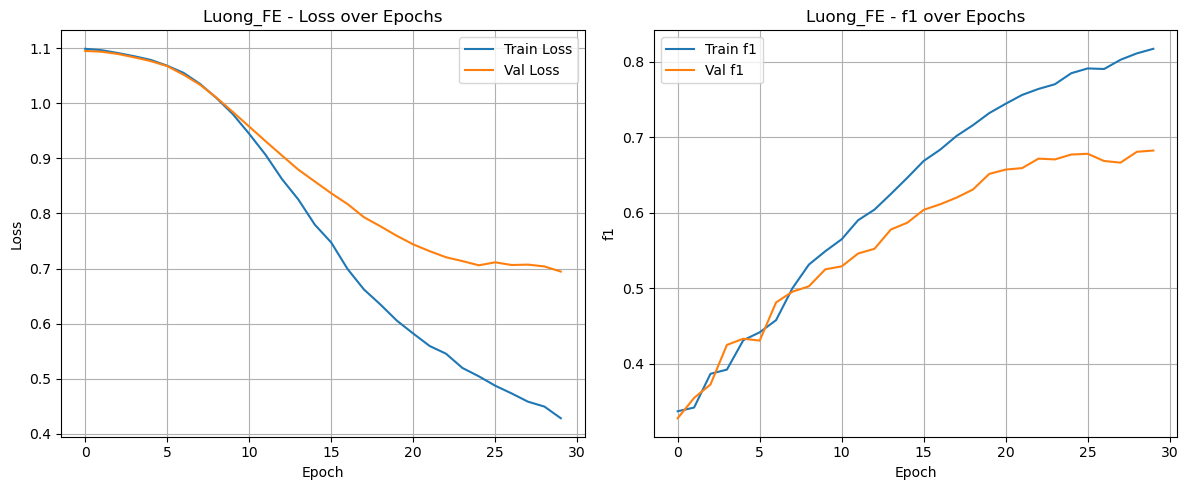

📈 Training history saved to: plots/saved/Luong_FE_plot.png


In [58]:
from plots.loss_val_plot import plot_training_history

plot_training_history(history, model_name=model_name)


🔍 Test Metrikleri - Luong_FE
Accuracy  : 0.6768
Precision : 0.6833
Recall    : 0.6822
F1 Score  : 0.6824


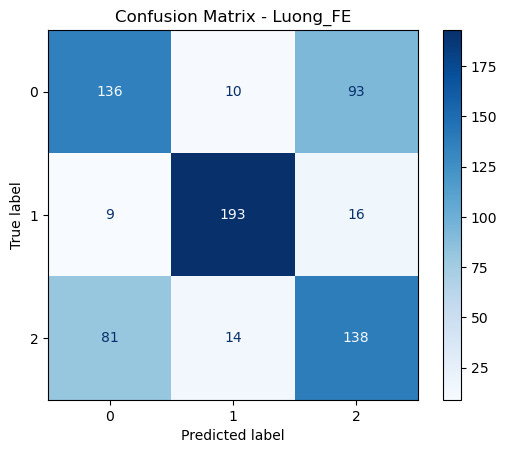

📌 Confusion matrix saved to: plots/saved/Luong_FE_csmtx.png


In [59]:
from plots.eval_plot_conf_mtx import evaluate_and_plot_confusion_matrix

metrics = evaluate_and_plot_confusion_matrix(
    model=model,
    src_tensor=src_tensor_test,
    trg_tensor=trg_tensor_test,
    device=device,
    model_name=model_name
)

In [60]:
infer_time = test_inference(model,sample)


🧠 Prediction for sample #10: Class 1
⚡ Inference Time for one sample : 1.48 ms


In [61]:
[main_result[k].append(v) for k, v in zip(['model_name',
                                           'Accuracy', 'Precision', 'Recall','F1',
                                           'Train_Time','Infer_Time'], [model_name,
                                                                       metrics['accuracy'], metrics['precision'], metrics['recall'],metrics['f1'],
                                                                      train_time, infer_time])]


[None, None, None, None, None, None, None]

# Scaled-dotProduct + FT-W2V

In [63]:
model_name='scaled-dot_FT-W2V'

In [64]:
attention= 'scaled_dot'

In [65]:
model, history, train_time = train_seq2seq_model(
    attention_module=attention,
    embedding_matrix=embedding_matrix,
    word2idx=word2idx,
    output_dim=OUTPUT_DIM,
    train_loader=train_loader,
    val_loader=val_loader,
    PAD_IDX=PAD_IDX,
    model_name=model_name,
    embedding_dim=emb_dim,
    hidden_dim=HIDDEN_DIM,
    EPOCHS=EPOCHS,
    CLASS_W=CLASS_WEIGHT,
)

Epoch 01 | Loss: 1.0914, F1: 0.3824 | Val_Loss: 1.0787, Val_F1: 0.4281
Epoch 02 | Loss: 1.0599, F1: 0.4720 | Val_Loss: 1.0343, Val_F1: 0.5201
Epoch 03 | Loss: 0.9946, F1: 0.5454 | Val_Loss: 0.9512, Val_F1: 0.5249
Epoch 04 | Loss: 0.8963, F1: 0.5499 | Val_Loss: 0.8435, Val_F1: 0.5782
Epoch 05 | Loss: 0.7881, F1: 0.6079 | Val_Loss: 0.7521, Val_F1: 0.6016
Epoch 06 | Loss: 0.7179, F1: 0.6123 | Val_Loss: 0.6924, Val_F1: 0.6052
Epoch 07 | Loss: 0.6679, F1: 0.6320 | Val_Loss: 0.6544, Val_F1: 0.6267
Epoch 08 | Loss: 0.6381, F1: 0.6440 | Val_Loss: 0.6288, Val_F1: 0.6554
Epoch 09 | Loss: 0.6123, F1: 0.6656 | Val_Loss: 0.6188, Val_F1: 0.6657
Epoch 10 | Loss: 0.6025, F1: 0.6624 | Val_Loss: 0.6138, Val_F1: 0.6545
Epoch 11 | Loss: 0.5937, F1: 0.6680 | Val_Loss: 0.6058, Val_F1: 0.6520
Epoch 12 | Loss: 0.5869, F1: 0.6783 | Val_Loss: 0.6050, Val_F1: 0.6438
Epoch 13 | Loss: 0.5834, F1: 0.6848 | Val_Loss: 0.6056, Val_F1: 0.6666
Epoch 14 | Loss: 0.5768, F1: 0.6951 | Val_Loss: 0.6069, Val_F1: 0.6514
Epoch 

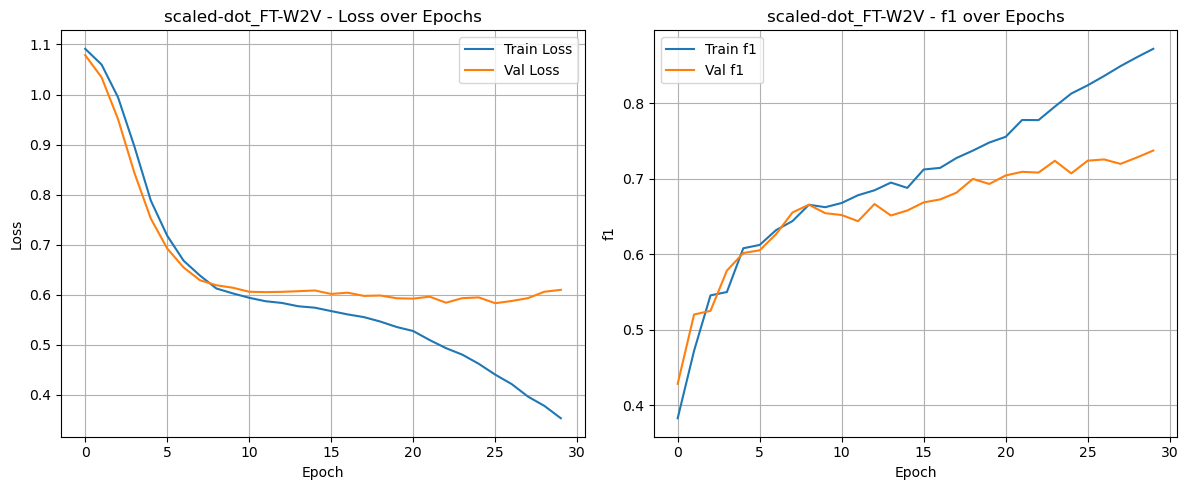

📈 Training history saved to: plots/saved/scaled-dot_FT-W2V_plot.png


In [66]:
from plots.loss_val_plot import plot_training_history

plot_training_history(history, model_name=model_name)


🔍 Test Metrikleri - scaled-dot_FT-W2V
Accuracy  : 0.7319
Precision : 0.7490
Recall    : 0.7357
F1 Score  : 0.7376


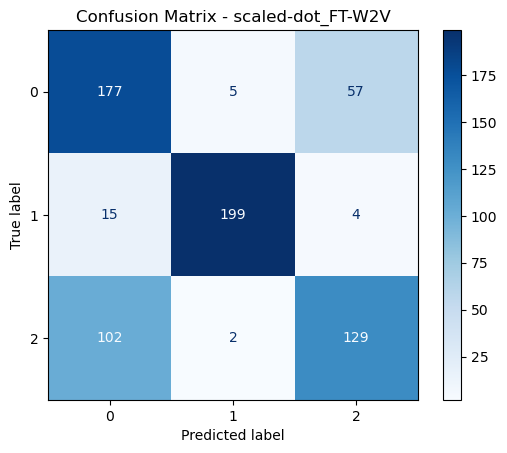

📌 Confusion matrix saved to: plots/saved/scaled-dot_FT-W2V_csmtx.png


In [67]:
from plots.eval_plot_conf_mtx import evaluate_and_plot_confusion_matrix

metrics = evaluate_and_plot_confusion_matrix(
    model=model,
    src_tensor=src_tensor_test,
    trg_tensor=trg_tensor_test,
    device=device,
    model_name=model_name
)

In [68]:
infer_time = test_inference(model,sample)


🧠 Prediction for sample #10: Class 1
⚡ Inference Time for one sample : 3.01 ms


In [69]:
[main_result[k].append(v) for k, v in zip(['model_name',
                                           'Accuracy', 'Precision', 'Recall','F1',
                                           'Train_Time','Infer_Time'], [model_name,
                                                                       metrics['accuracy'], metrics['precision'], metrics['recall'],metrics['f1'],
                                                                      train_time, infer_time])]


[None, None, None, None, None, None, None]

# Scaled-dotProduct + FE

In [71]:
model_name='scaled-dot_FE'

In [72]:
model, history, train_time = train_seq2seq_model(
    attention_module=attention,
    embedding_matrix=None,
    word2idx=word2idx,
    output_dim=OUTPUT_DIM,
    train_loader=train_loader,
    val_loader=val_loader,
    PAD_IDX=PAD_IDX,
    model_name=model_name,
    embedding_dim=emb_dim,
    hidden_dim=HIDDEN_DIM,
    EPOCHS=EPOCHS,
    CLASS_W=CLASS_WEIGHT,
)

Epoch 01 | Loss: 1.1007, F1: 0.3315 | Val_Loss: 1.0978, Val_F1: 0.2983
Epoch 02 | Loss: 1.0962, F1: 0.3605 | Val_Loss: 1.0932, Val_F1: 0.3914
Epoch 03 | Loss: 1.0941, F1: 0.3640 | Val_Loss: 1.0899, Val_F1: 0.4101
Epoch 04 | Loss: 1.0856, F1: 0.4122 | Val_Loss: 1.0837, Val_F1: 0.4598
Epoch 05 | Loss: 1.0764, F1: 0.4367 | Val_Loss: 1.0775, Val_F1: 0.4138
Epoch 06 | Loss: 1.0654, F1: 0.4557 | Val_Loss: 1.0633, Val_F1: 0.4741
Epoch 07 | Loss: 1.0482, F1: 0.4896 | Val_Loss: 1.0491, Val_F1: 0.4681
Epoch 08 | Loss: 1.0236, F1: 0.4981 | Val_Loss: 1.0272, Val_F1: 0.5035
Epoch 09 | Loss: 0.9998, F1: 0.5138 | Val_Loss: 1.0053, Val_F1: 0.5201
Epoch 10 | Loss: 0.9694, F1: 0.5422 | Val_Loss: 0.9818, Val_F1: 0.5115
Epoch 11 | Loss: 0.9359, F1: 0.5654 | Val_Loss: 0.9575, Val_F1: 0.5131
Epoch 12 | Loss: 0.8891, F1: 0.5927 | Val_Loss: 0.9065, Val_F1: 0.5622
Epoch 13 | Loss: 0.8070, F1: 0.6426 | Val_Loss: 0.8264, Val_F1: 0.6041
Epoch 14 | Loss: 0.7340, F1: 0.6693 | Val_Loss: 0.7621, Val_F1: 0.6289
Epoch 

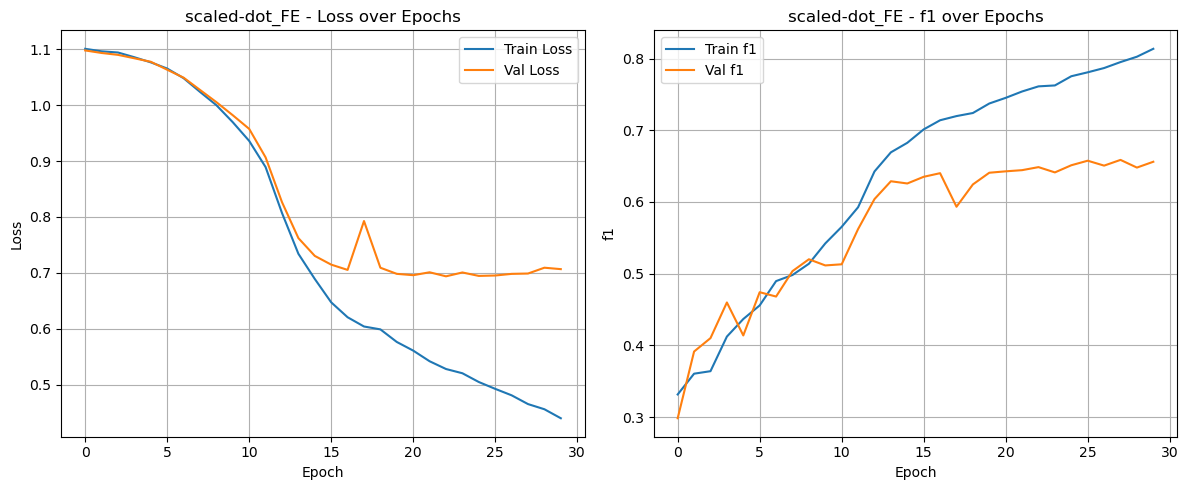

📈 Training history saved to: plots/saved/scaled-dot_FE_plot.png


In [73]:
from plots.loss_val_plot import plot_training_history

plot_training_history(history, model_name=model_name)


🔍 Test Metrikleri - scaled-dot_FE
Accuracy  : 0.6478
Precision : 0.6666
Recall    : 0.6530
F1 Score  : 0.6561


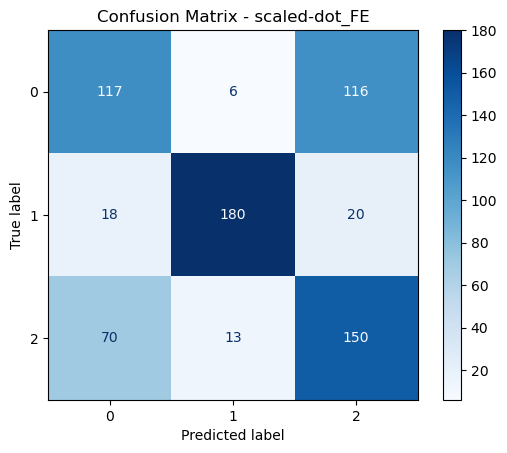

📌 Confusion matrix saved to: plots/saved/scaled-dot_FE_csmtx.png


In [74]:
from plots.eval_plot_conf_mtx import evaluate_and_plot_confusion_matrix

metrics = evaluate_and_plot_confusion_matrix(
    model=model,
    src_tensor=src_tensor_test,
    trg_tensor=trg_tensor_test,
    device=device,
    model_name=model_name
)

In [75]:
infer_time = test_inference(model,sample)


🧠 Prediction for sample #10: Class 1
⚡ Inference Time for one sample : 1.93 ms


In [76]:
[main_result[k].append(v) for k, v in zip(['model_name',
                                           'Accuracy', 'Precision', 'Recall','F1',
                                           'Train_Time','Infer_Time'], [model_name,
                                                                       metrics['accuracy'], metrics['precision'], metrics['recall'],metrics['f1'],
                                                                      train_time, infer_time])]


[None, None, None, None, None, None, None]

# result

In [78]:
main_result

{'model_name': ['bahdanau_FT-W2V',
  'bahdanau_FE',
  'Luong_FT-W2V',
  'Luong_FE',
  'scaled-dot_FT-W2V',
  'scaled-dot_FE'],
 'Accuracy': [0.744927536231884,
  0.6652173913043479,
  0.736231884057971,
  0.6768115942028986,
  0.7318840579710145,
  0.6478260869565218],
 'Precision': [0.7574679402564778,
  0.6712441248588038,
  0.7524470251718546,
  0.683291762201569,
  0.7490025340744372,
  0.6665766149526414],
 'Recall': [0.7494035167838765,
  0.6707848404985729,
  0.7399219501704838,
  0.6822111453109283,
  0.7356926264751177,
  0.6530015487942684],
 'F1': [0.7523891091502352,
  0.670522227876603,
  0.7422657183722251,
  0.6824341861327401,
  0.7375911421622323,
  0.6561236872086459],
 'Train_Time': [38990.96417427063,
  36004.82106208801,
  35195.47343254089,
  33450.79946517944,
  33595.99447250366,
  33468.181133270264],
 'Infer_Time': [2.719402313232422,
  2.0515918731689453,
  1.177072525024414,
  1.478433609008789,
  3.013134002685547,
  1.931905746459961]}

(<Figure size 1800x1000 with 3 Axes>,
 (<Axes: title={'center': 'Model Performance Metrics'}, ylabel='Value'>,
  <Axes: title={'center': 'Model Training and Inference Times'}, xlabel='Model', ylabel='Training Time (seconds)'>,
  <Axes: ylabel='Inference Time (seconds)'>))

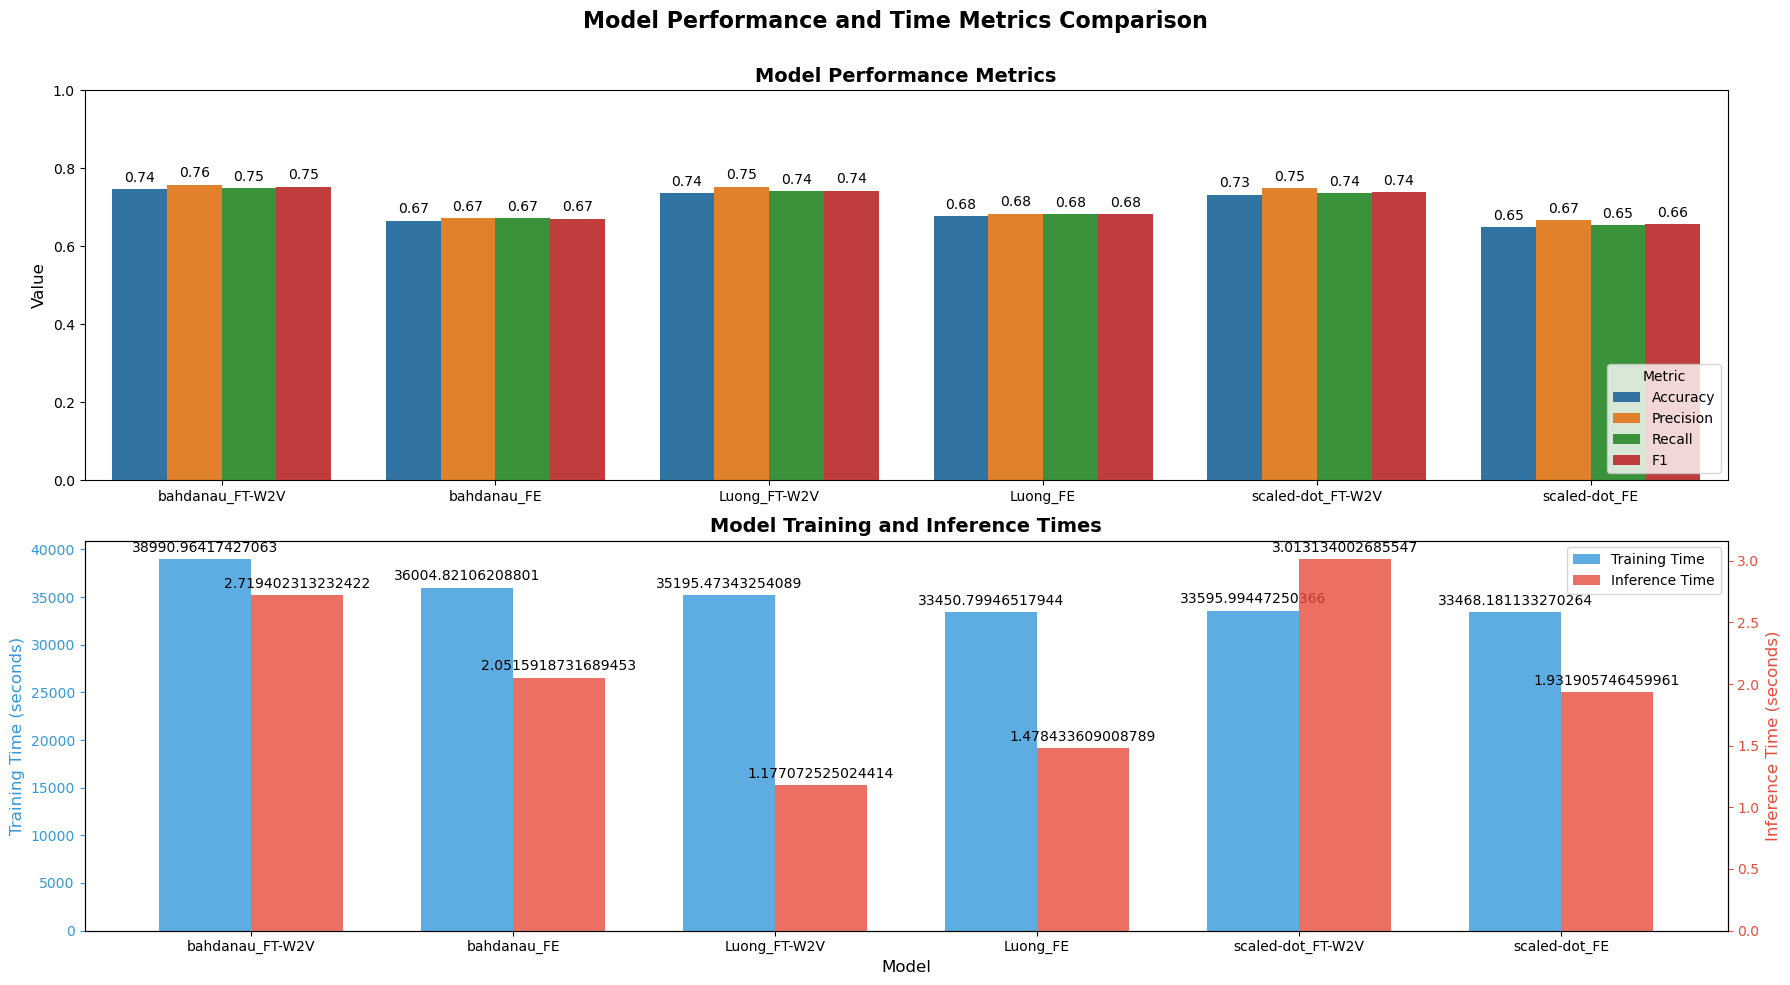

In [79]:
from plots.time_metric import plot_all_model_metrics

plot_all_model_metrics(main_result)

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Model Performance Metrics Comparison'}, xlabel='Model', ylabel='Value'>)

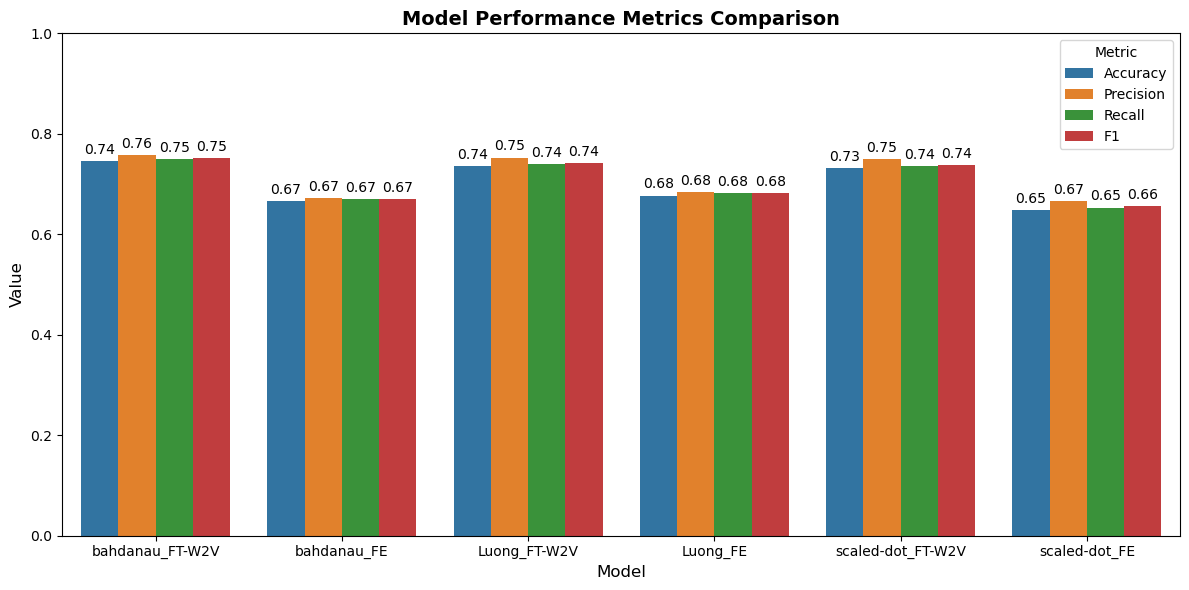

In [80]:
from plots.time_metric import plot_performance_metrics
plot_performance_metrics(main_result)

In [81]:
# AdditiveAttention + FT-W2V